In [1]:
import sys
import torch
import torch.nn.functional as F
from torch.utils.data import Subset
from torchvision.utils import save_image
import torchvision.models as tvmodels
from torchvision import datasets, transforms

import segmentation_models_pytorch as smp

import numpy as np

import matplotlib.pyplot as plt

sys.path.insert(0, "../src")
import exlib
from exlib.explainers import *
from exlib.modules import *
from exlib.datasets.abdomen_organs import *

In [2]:
DATA_DIR = "/home/antonxue/foo/data/abdomen_exlib/"
train_dataset = AbdomenOrgans(data_dir=DATA_DIR, split="train")
test_dataset = AbdomenOrgans(data_dir=DATA_DIR, split="test")

In [3]:
state_dict = torch.load("/home/antonxue/foo/real_drs/saved_models/weiqiu_model2.pt")

In [4]:
model = AbodmenSegModel(in_channels=3, out_channels=3)
# model.unet = smp.Unet(
#         encoder_name = "resnet50",
#         encoder_weights = "imagenet",
#         in_channels = 3,
#         classes = 3,
#         activation = "softmax2d"
#     )
# model.unet.load_state_dict(state_dict["model_state_dict"])
model.unet.eval()
model.eval();

In [5]:
x, olabel, glabel = test_dataset[2]
y = model(x[None,...])

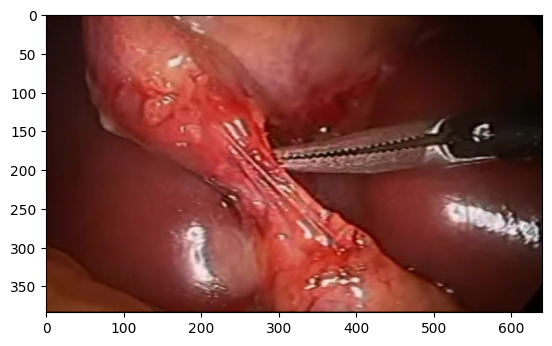

In [6]:
plt.imshow(x.numpy().transpose(1,2,0))

In [7]:
(y.argmax(dim=1) == 0).sum(), (y.argmax(dim=1) == 1).sum(), (y.argmax(dim=1) == 2).sum()

(tensor(184932), tensor(2), tensor(60826))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

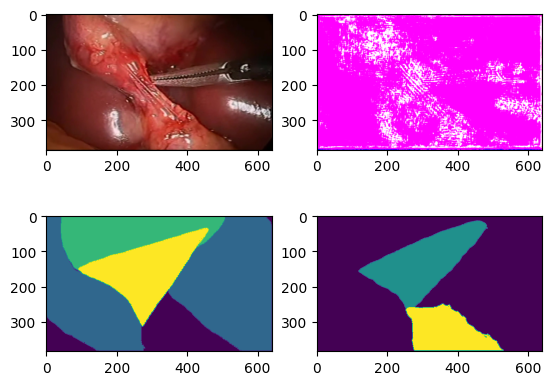

In [8]:
plt.figure()
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(x.numpy().transpose(1,2,0))
ax[0,1].imshow(40 * y[0].detach().numpy().transpose(1,2,0))
ax[1,0].imshow(30 * olabel.numpy().transpose(1,2,0))
ax[1,1].imshow(40 * glabel.numpy().transpose(1,2,0))

In [9]:
########################################
########################################
########################################

In [10]:
cls_model = AbdomenClsModel(3, 6)

In [11]:
X = torch.stack([x,x,x])
y = cls_model(X)
y

tensor([[ 0.7161, -0.2091,  0.2278, -0.5150,  0.0696,  0.2476],
        [ 0.7161, -0.2091,  0.2278, -0.5150,  0.0696,  0.2476],
        [ 0.7161, -0.2091,  0.2278, -0.5150,  0.0696,  0.2476]],
       grad_fn=<AddmmBackward0>)

In [12]:
# Try an explainer

In [13]:
# explainer = IntGradImageSeg(model)
intg_cls = IntGradImageCls(cls_model)
intg_seg = IntGradImageSeg(model)                       

lime_cls = LimeImageCls(cls_model)
lime_seg = LimeImageSeg(model)
lime_cls_old = TorchImageLime(cls_model)

In [14]:
intg_cls_exp = intg_cls(X, label=[0,1,2])

In [15]:
intg_cls_seg = intg_seg(X, label=[0,1,2])

In [16]:
lime_cls_exp = lime_cls(X, label=[0,1,2])

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [17]:
lime_seg_exp = lime_seg(X, label=[0,1,2])

  0%|          | 0/500 [00:00<?, ?it/s]

TypeError: 'NoneType' object is not callable

In [ ]:
lime_cls_old_exp = lime_cls_old(X, label=None)

In [ ]:
lime_seg_exp.attributions[0].sum(), lime_seg_exp.attributions[1].sum()

In [ ]:
plt.imshow(lime_seg_exp.attributions[0].numpy())

In [ ]:
plt.imshow(lime_seg_exp.attributions[1].numpy())

In [ ]:
plt.imshow(lime_seg_exp.attributions[2].numpy())

In [ ]:
#####

In [ ]:
shap_cls = TorchImageSHAP(cls_model)

In [ ]:
shap_cls_exp = shap_cls(X)

In [ ]:
shap_cls_exp.attributions.reshape(-1).sort()